<a href="https://colab.research.google.com/github/Zfeng0207/FIT3199-FYP/blob/dev%2Fzfeng/02_baseline_model_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Baseline Model Evaluation

In [6]:
!pip install -q mlflow shap lime

In [7]:
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.sparse import hstack
from sklearn.preprocessing import FunctionTransformer
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import lime
from lime.lime_tabular import LimeTabularExplainer
import os

### Import Clean Data

In [52]:
processed_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FIT3199-FYP/input/01_preprocessed_output.csv')

In [53]:
processed_df.drop(columns=['icd_code','icd_version','icd_title','subject_id','stay_id_x','stay_id_y'], inplace=True)

In [54]:
processed_df.dtypes

,0
charttime,object
temperature,float64
heartrate,float64
resprate,float64
o2sat,float64
sbp,float64
dbp,float64
rhythm,int64
pain,int64
seq_num,int64


In [55]:
# Convert the datetime column to datetime objects
processed_df['charttime'] = pd.to_datetime(processed_df['charttime'])

# Extract datetime components and add them as new columns
processed_df['year'] = processed_df['charttime'].dt.year
processed_df['month'] = processed_df['charttime'].dt.month
processed_df['day'] = processed_df['charttime'].dt.day
processed_df['hour'] = processed_df['charttime'].dt.hour
processed_df['minute'] = processed_df['charttime'].dt.minute
processed_df['second'] = processed_df['charttime'].dt.second

# Convert the datetime column to datetime objects
processed_df['dod'] = pd.to_datetime(processed_df['dod'])

# Extract datetime components and add them as new columns
processed_df['dod_year'] = processed_df['dod'].dt.year
processed_df['dod_month'] = processed_df['dod'].dt.month
processed_df['dod_day'] = processed_df['dod'].dt.day

processed_df.drop(columns=['charttime','dod'], inplace=True)


In [56]:
processed_df = processed_df.fillna({
    'subject_id': 0,  # Integer columns -> 0
    'stay_id_x': 0.0,  # Float columns -> 0.0
    'temperature': 0.0,  # Float columns -> 0.0
    'heartrate': 0.0,  # Float columns -> 0.0
    'resprate': 0.0,  # Float columns -> 0.0
    'o2sat': 0.0,  # Float columns -> 0.0
    'sbp': 0.0,  # Float columns -> 0.0
    'dbp': 0.0,  # Float columns -> 0.0
    'rhythm': 0,  # Integer columns -> 0
    'pain': 0,  # Integer columns -> 0
    'year': 0,  # Float columns -> 0.0
    'month': 0,  # Integer columns -> 0
    'day': 0,  # Integer columns -> 0
    'hour': 0,  # Integer columns -> 0
    'minute': 0,  # Integer columns -> 0
    'second': 0,  # Integer columns -> 0
    'dod_year': 0.0,  # String columns -> '0.0'
    'dod_month': 0.0,  # String columns -> '0.0'
    'dod_day': 0.0  # String columns -> '0.0'
})

In [57]:
# Print the updated DataFrame
print(processed_df)

       temperature  heartrate  resprate  o2sat    sbp    dbp  rhythm  pain  \
0             98.3       74.0      19.0   97.0  153.0   67.0      -1    70   
1              0.0       82.0      16.0   96.0  115.0  102.0      -1    -1   
2             98.0      109.0      18.0   98.0  113.0   77.0      -1    84   
3             99.9       74.0      16.0  100.0  151.0   76.0      -1    77   
4             98.4       83.0       0.0   94.0  142.0   81.0      -1    -1   
...            ...        ...       ...    ...    ...    ...     ...   ...   
52285         98.1       62.0      16.0  100.0  121.0   62.0      -1   119   
52286          0.0        0.0       0.0    0.0    0.0    0.0      -1    92   
52287         99.8       92.0      16.0   96.0  160.0   80.0      -1   304   
52288         97.9       63.0      20.0   99.0  149.0   97.0      -1    -1   
52289          0.0       66.0       0.0    0.0  156.0   76.0      -1    -1   

       seq_num  Stroke_Y/N  ...  anchor_year_group    year  mon

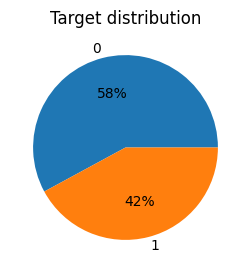

In [58]:
targets = processed_df['Stroke_Y/N']

temp = targets.value_counts()
temp

plt.figure(figsize=(6, 3))
plt.pie(temp, labels=temp.index, autopct="%.0f%%")
plt.title('Target distribution')
plt.show()

### Stratified Split
- First Split (80% train + 20% test)
- Second Split (80% train, 20% validation)


In [59]:
y = processed_df["Stroke_Y/N"]
X = processed_df.drop(columns=["Stroke_Y/N"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_val, X_val, y_train_val, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

In [60]:
y

,Stroke_Y/N
0,0
1,1
2,0
3,0
4,1
...,...
52285,1
52286,0
52287,0
52288,1


In [61]:
# # Save X_test and y_test
# X_test.to_csv("X_test.csv", index=False)
# y_test.to_csv("y_test.csv", index=False)

# # Save X_val and y_val
# X_val.to_csv("X_val.csv", index=False)
# y_val.to_csv("y_val.csv", index=False)

# print("Test and validation sets saved successfully.")


## Baseline Model Training

In [62]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

In [63]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# calculate metrics for validation set
val_f1 = f1_score(y_val, y_val_pred, average='weighted')
val_precision = precision_score(y_val, y_val_pred, average='weighted')
val_recall = recall_score(y_val, y_val_pred, average='weighted')
val_accuracy = accuracy_score(y_val, y_val_pred)

# calculate metrics for test set
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Validation Metrics:")
print(f"F1 Score: {val_f1:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"Accuracy: {val_accuracy:.4f}")
print()
print("Test Metrics:")
print(f"F1 Score: {test_f1:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")

Validation Metrics:
F1 Score: 0.9999
Precision: 0.9999
Recall: 0.9999
Accuracy: 0.9999

Test Metrics:
F1 Score: 0.9827
Precision: 0.9827
Recall: 0.9827
Accuracy: 0.9827


### SHAP and LIME Analysis

#### SHAP

In [64]:
#  create a SHAP explainer and calculate SHAP values for the test set
explainer_shap = shap.TreeExplainer(model)
shap_values = explainer_shap.shap_values(X_test)


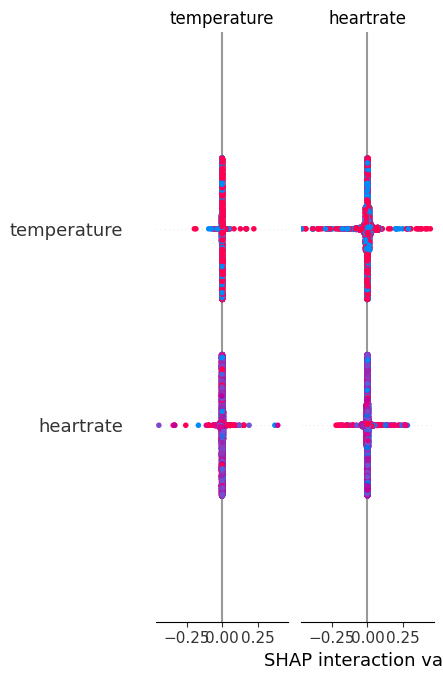

In [65]:
import shap
import matplotlib.pyplot as plt

# Create SHAP summary plot
shap.summary_plot(shap_values, X_test)


##### Summary Plot Insights

Notes:

**Observations**


**Key Takeaway**


In [66]:
X_test

,temperature,heartrate,resprate,o2sat,sbp,dbp,rhythm,pain,seq_num,gender,...,anchor_year_group,year,month,day,hour,minute,second,dod_year,dod_month,dod_day
28659,97.7,71.0,18.0,98.0,0.0,0.0,-1,28,3,0,...,0,2190.0,3.0,14.0,6.0,50.0,0.0,0.0,0.0,0.0
10906,0.0,91.0,18.0,95.0,132.0,62.0,-1,297,4,0,...,2,2135.0,10.0,14.0,8.0,30.0,0.0,0.0,0.0,0.0
42099,0.0,70.0,23.0,99.0,109.0,57.0,-1,28,1,1,...,1,2195.0,11.0,11.0,11.0,41.0,0.0,0.0,0.0,0.0
48071,98.2,75.0,19.0,0.0,129.0,89.0,-1,-1,1,0,...,0,2193.0,6.0,9.0,18.0,26.0,0.0,0.0,0.0,0.0
24773,0.0,0.0,0.0,97.0,118.0,67.0,-1,-1,2,1,...,1,2172.0,3.0,19.0,3.0,47.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13321,0.0,84.0,18.0,0.0,126.0,78.0,-1,-1,4,1,...,0,2128.0,1.0,18.0,21.0,42.0,0.0,0.0,0.0,0.0
23378,97.6,78.0,15.0,95.0,122.0,86.0,-1,28,1,0,...,1,2156.0,3.0,31.0,3.0,21.0,0.0,0.0,0.0,0.0
33210,97.9,68.0,20.0,100.0,133.0,57.0,-1,28,2,0,...,1,2152.0,12.0,8.0,7.0,33.0,0.0,0.0,0.0,0.0
27143,98.8,73.0,17.0,100.0,131.0,92.0,-1,-1,2,1,...,1,2126.0,3.0,2.0,13.0,13.0,0.0,0.0,0.0,0.0


##### Dependence Plot Insights

Notes:


**Observations**


**Key Takeaway**



#### LIME

In [67]:
# lime_explanation = explainer_lime.explain_instance(X_test.iloc[0].values, model.predict_proba, num_features=10)
# lime_explanation.as_pyplot_figure()
# plt.show()

##### Insights
**Observations**



**Key Takeaway**


### Model Tracking With MLFlow

In [68]:
!pip install -q mlflow pyngrok

In [69]:
import mlflow
from pyngrok import ngrok

# Start MLflow tracking server
get_ipython().system_raw("mlflow server --host 0.0.0.0 --port 8081 --backend-store-uri sqlite:///mlflow.db &")

# Expose the MLflow tracking server
public_url = ngrok.connect(8081).public_url
print(f"MLflow Tracking UI: {public_url}")

# Set MLflow tracking URI
mlflow.set_tracking_uri(public_url)

# Set Experiment
mlflow.set_experiment("Stroke Prediction Experiment")


ERROR:pyngrok.process.ngrok:t=2025-03-14T06:44:13+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-03-14T06:44:13+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-03-14T06:44:13+0000 lvl=eror msg="terminating with error" obj=app err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your aut

PyngrokNgrokError: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.

In [ ]:
train_data = X_train.copy()
train_data['category'] = y_train

val_data = X_val.copy()
val_data['category'] = y_val

test_data = X_test.copy()
test_data['category'] = y_test

In [ ]:
train_df = mlflow.data.from_pandas(train_data, source=preprocessed_data_path)
val_df = mlflow.data.from_pandas(val_data, source=preprocessed_data_path)
test_df = mlflow.data.from_pandas(test_data, source=preprocessed_data_path)

In [ ]:
# logging with MLflow

data_source_path = "preprocessed_data.csv"

with mlflow.start_run():

    # log the dataset used
    mlflow.log_input(train_df, context='training')
    mlflow.log_input(val_df, context='validation')
    mlflow.log_input(test_df, context='testing')

    #log artifacts, no parameters to log yet
    mlflow.log_artifact(data_source_path, artifact_path="model_data")


    # log tags
    mlflow.set_tags({
        "model_type": "RandomForest",
        "framework": "sklearn",
        "experiment_name": "Model_Experiment",
        "random_state": "42"
    })

    # log parameter source code
    mlflow.log_param("source_code", "train_model.py")  # Replace with your actual script/file

    # log model
    mlflow.sklearn.log_model(model, "model")

    # log metrics
    mlflow.log_metric("val_f1", val_f1)
    mlflow.log_metric("test_f1", test_f1)

    mlflow.log_metric("val_precision", val_precision)
    mlflow.log_metric("test_precision", test_precision)

    mlflow.log_metric("val_recall", val_recall)
    mlflow.log_metric("test_recall", test_recall)

    mlflow.log_metric("val_accuracy", val_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)